In [1]:
# Mounting GCS to colab
# https://stackoverflow.com/questions/51715268/how-to-import-data-from-google-cloud-storage-to-google-colab

# from google.colab import auth
# auth.authenticate_user()

In [7]:
# !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
# !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
# !apt -qq update
# !apt -qq install gcsfuse

In [6]:
# !mkdir colab_indoor
# !gcsfuse indoor-data colab_indoor
# !mkdir colab_indoor/train_2
# !gcsfuse indoor-data/train_2 colab_indoor/train_2
# !mkdir colab_indoor/test_2
# !gcsfuse indoor-data/test_2 colab_indoor/test_2

In [12]:
!ls -la -h ./colab_indoor/train_2

total 3.9G
-rw-r--r-- 1 root root 150M Mar 31 21:54 5a0546857ecc773753327266_train.csv
-rw-r--r-- 1 root root 142M Mar 31 21:54 5c3c44b80379370013e0fd2b_train.csv
-rw-r--r-- 1 root root 791M Mar 31 21:54 5d27075f03f801723c2e360f_train.csv
-rw-r--r-- 1 root root 216M Mar 31 21:54 5d27096c03f801723c31e5e0_train.csv
-rw-r--r-- 1 root root 126M Mar 31 21:54 5d27097f03f801723c320d97_train.csv
-rw-r--r-- 1 root root  19M Mar 31 21:54 5d27099f03f801723c32511d_train.csv
-rw-r--r-- 1 root root  24M Mar 31 21:54 5d2709a003f801723c3251bf_train.csv
-rw-r--r-- 1 root root 141M Mar 31 21:54 5d2709b303f801723c327472_train.csv
-rw-r--r-- 1 root root 202M Mar 31 21:54 5d2709bb03f801723c32852c_train.csv
-rw-r--r-- 1 root root 280M Mar 31 21:54 5d2709c303f801723c3299ee_train.csv
-rw-r--r-- 1 root root 103M Mar 31 21:54 5d2709d403f801723c32bd39_train.csv
-rw-r--r-- 1 root root  70M Mar 31 21:54 5d2709e003f801723c32d896_train.csv
-rw-r--r-- 1 root root 6.5M Mar 31 21:54 5da138274db8ce0c98bbd3d2_train.csv
-

In [150]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import lightgbm as lgb
import pickle

import math
import scipy.stats as stats

# from google.cloud import storage

pd.set_option("display.max_columns", 100)

In [151]:
SEED = 42
N_SPLITS = 10

In [152]:
# Comp metric
# def comp_metric(xhat, yhat, fhat, x, y, f):
#     intermediate = np.sqrt((xhat - x)**2 + (yhat - y)**2) + 15 * np.abs(fhat-f)
#     return intermediate.sum() / xhat.shape[0]

def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]

def score_log(df: pd.DataFrame, num_files: int, nam_file: str, data_shape: tuple, n_fold: int, seed: int, mpe: float):
    score_dict = {'n_files': num_files, 'file_name': nam_file, 'shape': data_shape, 'fold': n_fold, 'seed': seed, 'score': mpe}
    # print(score_dict)
    # noinspection PyTypeChecker
    df = pd.concat([df, pd.DataFrame.from_dict([score_dict])])
    df.to_csv("./colab_indoor/log_score.csv", index=False)
    return df

In [153]:
feature_dir = "./colab_indoor/"
train_files = sorted(glob.glob("./colab_indoor/train_2/*"))
test_files = sorted(glob.glob("./colab_indoor/test_2/*"))
# print(train_files[0], train_files[8], train_files[16], train_files[23])
# print(test_files[0], test_files[8], test_files[16], test_files[23])

In [154]:
# load submission file
sub_df = pd.read_csv("./colab_indoor/sample_submission.csv", index_col=0)
# sub_df[["site", "file", "timestamp"]] = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
display(sub_df.head())

,floor,x,y
site_path_timestamp,,,
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000000009,0,75.0,75.0
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000009017,0,75.0,75.0
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000015326,0,75.0,75.0
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000018763,0,75.0,75.0
5a0546857ecc773753327266_046cfa46be49fc10834815c6_0000000022328,0,75.0,75.0


---
## 1 model per site lgbm w/ KFold
---

In [155]:
df_train = pd.read_csv("./colab_indoor/train_2/5a0546857ecc773753327266_train.csv")
df_test = pd.read_csv("./colab_indoor/test_2/5a0546857ecc773753327266_test.csv")
display(df_train.head())
display(df_test.head())

,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,fd4804b1282054b5df1bc478fbcb73fbd1aa09cb,2253c6a0d0f7277737aa8e86e0484be805124806,2daa7fde27c0fd44e4a0133c3247be06d3c21c0b,ce0718d609ae0f06031490c462fff571210d0d0c,82385a56f25847fe6966d46bb58f302c4597953c,7f1bc20c9c21d1751f25e2ed5dbfda28e1b2554a,3fc1c8fa39c6996247670b3a9182b320dc3d9f0a,5baf7217c2d6e9596923d5e4349928f50c1a6d40,10983f664fc2be47f37d3bef4c78e2f088620fef,a35c02b945625781267821b43bd2eb609616ce65,26f99f7138f8721213e77ac21d013d4fa1716ef0,358dc9545d5faa51c88d04edf8c902068e13b106,3688b1d72f939347de1233defbb4f7ae706eb5ef,e62e836b877d4189e890fcc9d0d4d7d09964933a,4608951935961c98acdd8a88cb4d3dfd0358fa6c,9ad1d8c3a29b04ff542c90d2f6e05eaeddc42a97,d6a858af60bc6f39894eb9118b1aa44f8cfd6be2,84c47fac35ab22cce3e29d99206df390fc62bfb9,2853111b1aa4b4fa65f990a807bdac9ad39234cd,32a1feafe5029aaa6f9d8758d00a3e95aa4aa360,251db8e17c32d7583d547423ddcfcf443c1a7300,b55d25918e89d1e8a6eb2de4321296d6bded8164,3a6b2bc5f25fcaf92ec3cdfe2cc40889ef2fd6ab,7e793e674e6a70125eb9f1b0954ac20ce2f21472,5eb37c76fee8a970b031fe2912eb15e77797d6a5,ab94ebeb29cea34aed181638da81310ecc9cf966,2f9c36153f4f5d3f8b064455bdf725a48ef147ea,094c73b83a4c90cac6506c7029bf65b26f00d45f,9e716ffd84238082386afa4fd72cf4c8b68cbc93,9be03b4dda960a100a8ab2ea64201935102416f4,baf793b46eddbf0e62fd203631280d258247f7b3,508be8c7606b225ba9317af2471566cff4b12404,2d6473e9ead4570652c19816cc32184e24525956,8e7c6349b90405b521061126b261a85098b12753,72d202fe36ca3a3e1d0a83dd214cadef41af513f,883f6fb7e5ed079e2ebb46f59d089747862879f6,6d99fba05b779d8c6836f951f442fd2dbc002dc3,d3f1271c54b887004e5e6233290db6b010b56aba,590a67e91036954a6e427df1f635f0b3d95ab908,...,d7157844a7899c4ef0d2caa0b4518f21a3a3b1d1,ce9efeedc11a49c9de719ee5747a584bf3dc05b4,67c1d78314fedaf49a9e54ae3ed765cb9047c65c,ca2d4a7071d2cd34e6ff6a2d20f5e614efd33ba8,1c6c66fa50799c7d230a771ed86191649eeb868f,ded24932eef79bcb29e8fb27ec987661fba68550,305a7cba0b9e5c983ce179bfebfe72a92a9a66c7,e229e5b52a293e7e6f5112dd6c8f6be40789fe3f,8299cd39d69e1aec8f37ed2f895be4b9997e7a56,dd3a1c7dfdf95b1702afe637795f99a1dcc12db7,6f311690978e199e95ad23003eb1deb1d0b2f42b,7e44cc6c807fe154ba7fe97bca97030f6e610d2b,db2118bbf6034e55c8a594481aa87d6a67e3bfbb,d6f8e0a20a1a65b0ce10a3d58c3f3a8758a95e6f,f6b4a651fe2db1c68c3652da07f7869453adfee8,52991874f27e29074381dc2b6cf4267ba079564b,85f187bfc2e3a1eab8027c925690679c1de6b5c7,4ed61e923a531cd500928e7dcf4412d5dabdd4e6,8b59fb25bf867e2b57ba14cb71c386d202d714df,3e30d40b1f40522801cbb68a468b92414f1ccf13,98a30c53639727fd1f43c9ab4237c3c3f6153ada,aecd9cc3d0c1640e971226c67678032d65747459,1ae65ecc64fd68a95580a4d968f9c9f8cf777ae9,b71b9159ec25bd67017caa99494263086a5cd326,c26c54c0dfa013b4ee1e15a3f11bcfa8215c0a99,1b12eb877cf5261ab74957f2ca659ee89e858a42,6e53995eb99731c76e4804cb193e160d60e03cff,21d6b5544a59eac82f9bb8bf54105a41958adaf8,94f0be14f76dfbb65a8d9c920542f06e4f79fa26,a630919f315899ebf8650eb07d1097204ba5a2d3,6471b2899033a43f16bfd62b8198ef9557a49f62,43b75ab26009a503bb7cc0b4776edc6c27621ea7,27f2fa8a8809bc430be43ea21c8968ed8f98cef7,48be90ff375acd4d6a323e4d85ede7564cebd98a,380da08a7279a1947c76c0961bf2c7bfa8bb2eaf,b2ce01476d4f985ee9d0518d1eadf9ed18d236ad,9a08f3c0cf309d67555c8f9c6f64686b9ba2283d,16f0057b4591b780054a4f2867ba3fa9ec793438,2e985809d94e7cfe3dbdc78a27e17baa56bef58b,1ad3144a286d2b32af03f8e275191f8c48c77e10,8c1eceb10a2c1b8d943f836acf2444392250f685,2a1bd89115889eacd8ef93c0fa2584e238a098a8,d16001127911cd8aad3e6e09663802d8748cd68e,e95654c4ebc092ae1845ba174839a8fc0e5c92b4,35e02baaefd4e7c076667ecadce166c2d2f09977,d90ab0610e02c2adb1174feaf719b9e506564893,01ead5ee97d0329b2c228fece5a96b0358a3cab1,8c077f9959ff86dc9f8836444618c2483f12e1ba,31595a6c2bd3a944b144685a2f117715520fd417,ecb87e6c93dd3c6cdb6f6671e25e2d0d6f865875
0,1578470975068,1913,141.92305,82.461280,B1,-1,5e158ecff4c3420006d52164,5a0546857ecc773753327266,0.200166,4.061169,8.532993,-47,-52,-54,-54,-54,-54,-59,-61,-66,-69,-76,-77,-77,-77,-77,-77,-78,-78,-78,-78,-78,-79,-79,-79,-79,-79,-79,-80,-80,-80,-80,-80,-80,-80,

,site_path_timestamp,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,eebf5db207eec2f3e041f92153d789270f346821,7805f319f3f591986effe78c5b41143180278f2d,323607d8444900d64151ee06d164738ac727bbce,b26914599f6d9ba16b43975394e1eeb9d82f4bab,02a1be3a5dab38320f879489d8a1e0f2a72768b3,5b225e187d0dec3110683a74d0c9a5a4cb2022f5,d84cce12fbfba61bf930123050f61a11e2a29310,b2546cae6e588d38618eacc557dd0385812197cf,6bc91b3951089c3a225396608b138ca178479924,8464ea586ee5479e1250f938d7c01e9bc68cefe8,b4dbb0b30caa1d0f21b7b4185ba061556cada67a,c48db7f3ed1858bb4fc191230e3d79d5eb178604,d771612396c3e2e557e986fafd9fc2c56a99d3cd,13b7aeaf441f2161481481fe67eace721cff07ab,dbd15d19abe3f9062b14bc403a499a66aa46cf26,c729e2e4f5a2888583cfebcd98b3178023f58b8e,bd9bc0a2092c040bfe6ba12f8aafac24e83b312a,c89453b4f0bde9488ef373a40d8821f4bf81beae,000840e5c600de293cea57f13326f273c86c3988,f64c13fd10a07bca1bf2b7bd7a80630632ce62c9,f2eb513d4c87747d0e4bc8c3bbf12951b3819678,e85bfadc24ead00bb0d80a56a2b24f5baee7da4a,ea4208f40a36b18be923fcd5adb59b250d9cef96,6915ad24a2edf8047f749233e19e9853f5dc17fd,15d53b7189ffbd7c6010c388a9ccea417d4f28ee,de53ffe7e3c71c9ed5c845fa50e0521efa5f3685,cbc6658be86ed0a5f49e670dcdb61924eee2ba0a,9ea330be4787b838d931c30f76aa9eb4ab69367e,0c75aad30012f215ae9377700feb44ee1ce42b88,15705627b6d4a0995188c4a97eb3bb604abcc401,39e2a4fb550a6b4a0feb5f0ff7b07754b1e27eaa,326e159e0dbace167726287290620e11367bb15a,85e6e3acc4f0005b00f70931e3f268bdf650956c,01da12eb27c6e37d03d691c31b40591a724db4a2,defb1317debff80bbec8fcdb53132edf3988ba93,8603dca5ec5f3485d28b66fd818ee3540301bc79,fc77794b1f306779e6d47c93b26bca7b229a6da9,69b30a314f33a8bafe26c9543bac3026b6171e18,...,e12a88f10345975e3337e9cf43a8a46fa68ffe3e,0e384fa31a858c85d686c23c84f02c539d6084d6,ca1b1ddbb06410ff4db1293fa32fa91922348cb6,1467cad993c176879919f34cdc1637ab5e719a89,f72e76e1198e03e8747cbab7d5eb7c8892236538,3e83518fabdba187f3d68e47a4751cce50e936fc,93be1230aaaa3c8f6394bfd274e6926c82b83f49,33f20983b8fae7222236a28f2fcdbfd0a64d3dae,c420057010e6ee7a7f310ea43fb563cf8b84403c,26f259dfcfeb99e4904a2fe617dab5dadce2a032,ead4eb320daf267710b8ec2f80b572ef14ca55f6,a19dac7dbdfd5b1628917159bb0333d0b4248b01,a5fa56c01bc636432ad0deb09ac769dd8b4bc4c5,c3403babce8901fd7a22f2752ee27e55c93137ef,e8af39b7dfe78bd5413b4af4a667d052e8cbaa77,fb91245a09b92f24ae14fc6e76e1b3549bd6a31d,0697d08b2741a320bcdcbb9624caca0e3a415356,2d199d76f05af1ff3432955b6b52163e8341dda5,b37d43c8c5f1e82765b5a403c19529d89b765d62,0076ff7a084cb2ac8c146139965ab1be296e72c4,b896a2a793aa802db868a7a0fdb29204bde99065,108716739163fd1a6e473359330704f7cd2068f7,e32d9e78dd87486b832f7723c916ca93ad686a54,1ad3144a286d2b32af03f8e275191f8c48c77e10,38f586d6a54a75a4fc9df0325de877b2bce5de6b,097599fa8b0d2bb4426ba0dae5ca9e578cdb8149,dc522df53e28d76a729dc56f81b1295a50ce4289,042e55ae2e3aae88070d507977eb97cd7468ef80,3b61536817d546393995f664b446e4ecf609ed61,295dcf2d00e2d19d02f73fc1d498ed5ca821161c,647649398bea2985feed4728d748939666dfb609,f3d9e7d629e50b8ca7e330d1d7cc11d6a75def8f,c70a6973225a173d7a0f74ca0ff93d07d140ed9d,a9f2d89eb253ffaf137bad7322e7cae41cd575d7,da8b535fe9eb7c6ea9388d1d2c4c80777da0fa2f,315dc4970761f38035d1da2d3592624abf1293ab,cb7c0d32ada93bf41f44aa2b37a5c584e894e040,96524d4078bf26b236a6ccc4efcf8bfb14189ab4,72a8a758661a41895e424613d666109e838b3d5f,af03d645e2ce58455848037f78dc79d962ec95d2,b831c303c1abd40fd8b242f902b6d900bca585af,c87c9fe93ddb4dc25d1d241c87a340ecf5be19f5,6bcdb1157c0d47e8a75d4ae864210156ebc2de96,817b99c65c4d92ab758443590680da2c3129c62b,563c56cbd1eba74106d9d4cf3adef19ddd574858,24f7fe5fa290f803c49bac656c57df514b180b4b,7e642dee5535c87ae5d65d225ee5dab01769b04c,ae2a68d930d314c1c164485b9ac5ef5beb158290,c5de94605289a9fae1869b9c73dde7806c559717,ed61d67ab40541ebb671536a7ea20125119cb964
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,2340,2331,-999.0,-999.0,-999.0,-999.0,046cfa46be49fc10834815c6,5a0546857ecc773753327266,0.010261,4.226973,8.941809,-45,-46,-46,-47,-47,-48,-48,-48,-48,-48,-49,-49,-49,-49,-49,-50,-50,-50,-51,-51,-51,-51,-51,-52,-52,-52,-53,-55,-5

In [156]:
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 50000,
              'learning_rate': 0.1,
              'num_leaves': 90,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

lgb_f_params = {'objective': 'multiclass',
                'boosting_type': 'gbdt',
                'n_estimators': 50000,
                'learning_rate': 0.1,
                'num_leaves': 90,
                'colsample_bytree': 0.4,
                'subsample': 0.6,
                'subsample_freq': 2,
                'bagging_seed': SEED,
                'reg_alpha': 10,
                'reg_lambda': 2,
                'random_state': SEED,
                'n_jobs': -1
                }

In [ ]:
score_df = pd.DataFrame()
oof = list()
predictions = list()


for n_files, file in enumerate(train_files):
    print("file:", file)
    start = time.time()

    data = pd.read_csv(file)
    test_data = pd.read_csv(test_files[n_files])

    oof_x, oof_y, oof_f = np.zeros(data.shape[0]), np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0
    preds_f_arr = np.zeros((test_data.shape[0], N_SPLITS))

    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    for fold, (trn_idx, val_idx) in enumerate(kf.split(data)):

        # Filter the features data to the columns needed
        all_cols = list(data.columns)
        remove_cols = ["wifi_ts", "x", "y", "floor", "floor_int", "file_id", "site_id"]
        cols = [x for x in all_cols if x not in remove_cols]
        # print("col before: ", len(cols))

        # filter test_data to only the needed columns
        all_test_cols = list(test_data.columns)
        remove_test_cols = ["site_path_timestamp", "wifi_ts", "x", "y", "floor", "floor_int", "file_id", "site_id"]
        test_cols = [x for x in all_test_cols if x not in remove_test_cols]
        # print("test col before: ", len(test_cols))

        # filter out any non-overlapping columns
        no_overlap_col = list(set(all_cols) ^ set(all_test_cols))
        cols = [x for x in cols if x not in no_overlap_col]
        test_cols = [x for x in test_cols if x not in no_overlap_col]
        # print("col after: ", len(cols))
        # print("test_col after: ", len(test_cols))

        X_train = data[cols].iloc[trn_idx, :]
        y_trainx = data.iloc[trn_idx, 2]
        y_trainy = data.iloc[trn_idx, 3]
        y_trainf = data.iloc[trn_idx, 5]

        X_valid = data[cols].iloc[val_idx, :]
        y_validx = data.iloc[val_idx, 2]
        y_validy = data.iloc[val_idx, 3]
        y_validf = data.iloc[val_idx, 5]

        modelx = lgb.LGBMRegressor(**lgb_params)
        modelx.fit(X_train, y_trainx,
                    eval_set=[(X_valid, y_validx)],
                    eval_metric='rmse',
                    verbose=False,
                    early_stopping_rounds=20
                    )

        modely = lgb.LGBMRegressor(**lgb_params)
        modely.fit(X_train, y_trainy,
                    eval_set=[(X_valid, y_validy)],
                    eval_metric='rmse',
                    verbose=False,
                    early_stopping_rounds=20
                    )

        modelf = lgb.LGBMClassifier(**lgb_f_params)
        modelf.fit(X_train, y_trainf,
                    eval_set=[(X_valid, y_validf)],
                    eval_metric='multi_logloss',
                    verbose=False,
                    early_stopping_rounds=20
                    )

        oof_x[val_idx] = modelx.predict(X_valid)
        oof_y[val_idx] = modely.predict(X_valid)
        oof_f[val_idx] = modelf.predict(X_valid).astype(int)

        preds_x += modelx.predict(test_data[cols]) / N_SPLITS
        preds_y += modely.predict(test_data[cols]) / N_SPLITS
        preds_f_arr[:, fold] = modelf.predict(test_data[cols]).astype(int)

        score = comp_metric(oof_x[val_idx], oof_y[val_idx], oof_f[val_idx],
                            y_validx.to_numpy(), y_validy.to_numpy(), y_validf.to_numpy())
        print(f"fold {fold}: mean position error {score}")
        score_df = score_log(score_df, n_files, os.path.basename(file), data.shape, fold, SEED, score)
        # display(score_df.head())

    print("*+"*40)
    print(f"file #{n_files}, shape={data.shape}, name={os.path.basename(file)}")
    score = comp_metric(oof_x, oof_y, oof_f,
                        data.iloc[:, 2].to_numpy(), data.iloc[:, 3].to_numpy(), data.iloc[:, 5].to_numpy())
    oof.append(score)
    print(f"mean position error {score}")
    print("*+"*40)
    score_df = score_log(score_df, n_files, os.path.basename(file), data.shape, 999, SEED, score)

    preds_f_mode = stats.mode(preds_f_arr, axis=1)
    preds_f = preds_f_mode[0].astype(int).reshape(-1)
    test_preds = pd.DataFrame(np.stack((preds_f, preds_x, preds_y))).T
    test_preds.columns = sub_df.columns
    test_preds.index = test_data["site_path_timestamp"]
    test_preds["floor"] = test_preds["floor"].astype(int)
    predictions.append(test_preds)

    print(f"time to process {file}:", time.time() - start)

file: ./colab_indoor/train_2/5a0546857ecc773753327266_train.csv


In [ ]:
# ------------------------------------------------------------------------------
# Submit the result
# ------------------------------------------------------------------------------
all_preds = pd.concat(predictions)
all_preds = all_preds.reindex(sub_df.index)
all_preds.to_csv('./colab_indoor/submission.csv')

---
## Initial baseline lgbm w/o KFold
---

In [52]:
# Load one train file
df_train = pd.read_csv("./colab_indoor/train_2/5a0546857ecc773753327266_train.csv")
print(len(df_train.columns))
print(len(df_train))
display(df_train.head())

3408
9296


,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,fd4804b1282054b5df1bc478fbcb73fbd1aa09cb,2253c6a0d0f7277737aa8e86e0484be805124806,2daa7fde27c0fd44e4a0133c3247be06d3c21c0b,ce0718d609ae0f06031490c462fff571210d0d0c,82385a56f25847fe6966d46bb58f302c4597953c,7f1bc20c9c21d1751f25e2ed5dbfda28e1b2554a,3fc1c8fa39c6996247670b3a9182b320dc3d9f0a,5baf7217c2d6e9596923d5e4349928f50c1a6d40,10983f664fc2be47f37d3bef4c78e2f088620fef,a35c02b945625781267821b43bd2eb609616ce65,26f99f7138f8721213e77ac21d013d4fa1716ef0,358dc9545d5faa51c88d04edf8c902068e13b106,3688b1d72f939347de1233defbb4f7ae706eb5ef,e62e836b877d4189e890fcc9d0d4d7d09964933a,4608951935961c98acdd8a88cb4d3dfd0358fa6c,9ad1d8c3a29b04ff542c90d2f6e05eaeddc42a97,d6a858af60bc6f39894eb9118b1aa44f8cfd6be2,84c47fac35ab22cce3e29d99206df390fc62bfb9,2853111b1aa4b4fa65f990a807bdac9ad39234cd,32a1feafe5029aaa6f9d8758d00a3e95aa4aa360,251db8e17c32d7583d547423ddcfcf443c1a7300,b55d25918e89d1e8a6eb2de4321296d6bded8164,3a6b2bc5f25fcaf92ec3cdfe2cc40889ef2fd6ab,7e793e674e6a70125eb9f1b0954ac20ce2f21472,5eb37c76fee8a970b031fe2912eb15e77797d6a5,ab94ebeb29cea34aed181638da81310ecc9cf966,2f9c36153f4f5d3f8b064455bdf725a48ef147ea,094c73b83a4c90cac6506c7029bf65b26f00d45f,9e716ffd84238082386afa4fd72cf4c8b68cbc93,9be03b4dda960a100a8ab2ea64201935102416f4,baf793b46eddbf0e62fd203631280d258247f7b3,508be8c7606b225ba9317af2471566cff4b12404,2d6473e9ead4570652c19816cc32184e24525956,8e7c6349b90405b521061126b261a85098b12753,72d202fe36ca3a3e1d0a83dd214cadef41af513f,883f6fb7e5ed079e2ebb46f59d089747862879f6,6d99fba05b779d8c6836f951f442fd2dbc002dc3,d3f1271c54b887004e5e6233290db6b010b56aba,590a67e91036954a6e427df1f635f0b3d95ab908,...,d7157844a7899c4ef0d2caa0b4518f21a3a3b1d1,ce9efeedc11a49c9de719ee5747a584bf3dc05b4,67c1d78314fedaf49a9e54ae3ed765cb9047c65c,ca2d4a7071d2cd34e6ff6a2d20f5e614efd33ba8,1c6c66fa50799c7d230a771ed86191649eeb868f,ded24932eef79bcb29e8fb27ec987661fba68550,305a7cba0b9e5c983ce179bfebfe72a92a9a66c7,e229e5b52a293e7e6f5112dd6c8f6be40789fe3f,8299cd39d69e1aec8f37ed2f895be4b9997e7a56,dd3a1c7dfdf95b1702afe637795f99a1dcc12db7,6f311690978e199e95ad23003eb1deb1d0b2f42b,7e44cc6c807fe154ba7fe97bca97030f6e610d2b,db2118bbf6034e55c8a594481aa87d6a67e3bfbb,d6f8e0a20a1a65b0ce10a3d58c3f3a8758a95e6f,f6b4a651fe2db1c68c3652da07f7869453adfee8,52991874f27e29074381dc2b6cf4267ba079564b,85f187bfc2e3a1eab8027c925690679c1de6b5c7,4ed61e923a531cd500928e7dcf4412d5dabdd4e6,8b59fb25bf867e2b57ba14cb71c386d202d714df,3e30d40b1f40522801cbb68a468b92414f1ccf13,98a30c53639727fd1f43c9ab4237c3c3f6153ada,aecd9cc3d0c1640e971226c67678032d65747459,1ae65ecc64fd68a95580a4d968f9c9f8cf777ae9,b71b9159ec25bd67017caa99494263086a5cd326,c26c54c0dfa013b4ee1e15a3f11bcfa8215c0a99,1b12eb877cf5261ab74957f2ca659ee89e858a42,6e53995eb99731c76e4804cb193e160d60e03cff,21d6b5544a59eac82f9bb8bf54105a41958adaf8,94f0be14f76dfbb65a8d9c920542f06e4f79fa26,a630919f315899ebf8650eb07d1097204ba5a2d3,6471b2899033a43f16bfd62b8198ef9557a49f62,43b75ab26009a503bb7cc0b4776edc6c27621ea7,27f2fa8a8809bc430be43ea21c8968ed8f98cef7,48be90ff375acd4d6a323e4d85ede7564cebd98a,380da08a7279a1947c76c0961bf2c7bfa8bb2eaf,b2ce01476d4f985ee9d0518d1eadf9ed18d236ad,9a08f3c0cf309d67555c8f9c6f64686b9ba2283d,16f0057b4591b780054a4f2867ba3fa9ec793438,2e985809d94e7cfe3dbdc78a27e17baa56bef58b,1ad3144a286d2b32af03f8e275191f8c48c77e10,8c1eceb10a2c1b8d943f836acf2444392250f685,2a1bd89115889eacd8ef93c0fa2584e238a098a8,d16001127911cd8aad3e6e09663802d8748cd68e,e95654c4ebc092ae1845ba174839a8fc0e5c92b4,35e02baaefd4e7c076667ecadce166c2d2f09977,d90ab0610e02c2adb1174feaf719b9e506564893,01ead5ee97d0329b2c228fece5a96b0358a3cab1,8c077f9959ff86dc9f8836444618c2483f12e1ba,31595a6c2bd3a944b144685a2f117715520fd417,ecb87e6c93dd3c6cdb6f6671e25e2d0d6f865875
0,1578470975068,1913,141.92305,82.461280,B1,-1,5e158ecff4c3420006d52164,5a0546857ecc773753327266,0.200166,4.061169,8.532993,-47,-52,-54,-54,-54,-54,-59,-61,-66,-69,-76,-77,-77,-77,-77,-77,-78,-78,-78,-78,-78,-79,-79,-79,-79,-79,-79,-80,-80,-80,-80,-80,-80,-80,

In [53]:
print(df_train.iloc[:, :15].info())
print(df_train.dtypes[df_train.dtypes == "object"])
# print(df_train.dtypes[df_train.dtypes == "category"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9296 entries, 0 to 9295
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   wifi_ts                                   9296 non-null   int64  
 1   wps_diff                                  9296 non-null   int64  
 2   x                                         9296 non-null   float64
 3   y                                         9296 non-null   float64
 4   floor                                     9296 non-null   object 
 5   floor_int                                 9296 non-null   int64  
 6   file_id                                   9296 non-null   object 
 7   site_id                                   9296 non-null   object 
 8   acce_x_avg                                9296 non-null   float64
 9   acce_y_avg                                9296 non-null   float64
 10  acce_z_avg                          

In [54]:
# Try training for one site wit LGBM

# dataset prep for training
target_x = df_train.iloc[:, 2]
target_y = df_train.iloc[:, 3]
target_f = df_train.iloc[:, 5]

# drop target columns
drop_cols = ["wifi_ts", "x", "y", "floor", "floor_int", "file_id"] # Train 5
features = df_train.drop(columns=drop_cols)
display(features.head())

# Convert object columns to category
categorical_features = ["site_id"]

# convert to category from object dtype
for col in categorical_features:
    features[col] = features[col].astype("category")

print(features.iloc[:, :15].info())

,wps_diff,site_id,acce_x_avg,acce_y_avg,acce_z_avg,fd4804b1282054b5df1bc478fbcb73fbd1aa09cb,2253c6a0d0f7277737aa8e86e0484be805124806,2daa7fde27c0fd44e4a0133c3247be06d3c21c0b,ce0718d609ae0f06031490c462fff571210d0d0c,82385a56f25847fe6966d46bb58f302c4597953c,7f1bc20c9c21d1751f25e2ed5dbfda28e1b2554a,3fc1c8fa39c6996247670b3a9182b320dc3d9f0a,5baf7217c2d6e9596923d5e4349928f50c1a6d40,10983f664fc2be47f37d3bef4c78e2f088620fef,a35c02b945625781267821b43bd2eb609616ce65,26f99f7138f8721213e77ac21d013d4fa1716ef0,358dc9545d5faa51c88d04edf8c902068e13b106,3688b1d72f939347de1233defbb4f7ae706eb5ef,e62e836b877d4189e890fcc9d0d4d7d09964933a,4608951935961c98acdd8a88cb4d3dfd0358fa6c,9ad1d8c3a29b04ff542c90d2f6e05eaeddc42a97,d6a858af60bc6f39894eb9118b1aa44f8cfd6be2,84c47fac35ab22cce3e29d99206df390fc62bfb9,2853111b1aa4b4fa65f990a807bdac9ad39234cd,32a1feafe5029aaa6f9d8758d00a3e95aa4aa360,251db8e17c32d7583d547423ddcfcf443c1a7300,b55d25918e89d1e8a6eb2de4321296d6bded8164,3a6b2bc5f25fcaf92ec3cdfe2cc40889ef2fd6ab,7e793e674e6a70125eb9f1b0954ac20ce2f21472,5eb37c76fee8a970b031fe2912eb15e77797d6a5,ab94ebeb29cea34aed181638da81310ecc9cf966,2f9c36153f4f5d3f8b064455bdf725a48ef147ea,094c73b83a4c90cac6506c7029bf65b26f00d45f,9e716ffd84238082386afa4fd72cf4c8b68cbc93,9be03b4dda960a100a8ab2ea64201935102416f4,baf793b46eddbf0e62fd203631280d258247f7b3,508be8c7606b225ba9317af2471566cff4b12404,2d6473e9ead4570652c19816cc32184e24525956,8e7c6349b90405b521061126b261a85098b12753,72d202fe36ca3a3e1d0a83dd214cadef41af513f,883f6fb7e5ed079e2ebb46f59d089747862879f6,6d99fba05b779d8c6836f951f442fd2dbc002dc3,d3f1271c54b887004e5e6233290db6b010b56aba,590a67e91036954a6e427df1f635f0b3d95ab908,ca7b16dd3dfc38309569d7db7ef2bf1f206c8c12,3b9ac7d40ec22f6f49c5e5b0d8d21bc35ac13466,b3d862416ca21ec29ae77e762d4e897935bac7e5,a5ff1142b331a09c85a606689e3a1c4702f6b6bc,acccd377c64a35e52d69b9e13f2f28f80a7d436e,a117ac96662544a01f7fac778029bf99df26ac64,...,d7157844a7899c4ef0d2caa0b4518f21a3a3b1d1,ce9efeedc11a49c9de719ee5747a584bf3dc05b4,67c1d78314fedaf49a9e54ae3ed765cb9047c65c,ca2d4a7071d2cd34e6ff6a2d20f5e614efd33ba8,1c6c66fa50799c7d230a771ed86191649eeb868f,ded24932eef79bcb29e8fb27ec987661fba68550,305a7cba0b9e5c983ce179bfebfe72a92a9a66c7,e229e5b52a293e7e6f5112dd6c8f6be40789fe3f,8299cd39d69e1aec8f37ed2f895be4b9997e7a56,dd3a1c7dfdf95b1702afe637795f99a1dcc12db7,6f311690978e199e95ad23003eb1deb1d0b2f42b,7e44cc6c807fe154ba7fe97bca97030f6e610d2b,db2118bbf6034e55c8a594481aa87d6a67e3bfbb,d6f8e0a20a1a65b0ce10a3d58c3f3a8758a95e6f,f6b4a651fe2db1c68c3652da07f7869453adfee8,52991874f27e29074381dc2b6cf4267ba079564b,85f187bfc2e3a1eab8027c925690679c1de6b5c7,4ed61e923a531cd500928e7dcf4412d5dabdd4e6,8b59fb25bf867e2b57ba14cb71c386d202d714df,3e30d40b1f40522801cbb68a468b92414f1ccf13,98a30c53639727fd1f43c9ab4237c3c3f6153ada,aecd9cc3d0c1640e971226c67678032d65747459,1ae65ecc64fd68a95580a4d968f9c9f8cf777ae9,b71b9159ec25bd67017caa99494263086a5cd326,c26c54c0dfa013b4ee1e15a3f11bcfa8215c0a99,1b12eb877cf5261ab74957f2ca659ee89e858a42,6e53995eb99731c76e4804cb193e160d60e03cff,21d6b5544a59eac82f9bb8bf54105a41958adaf8,94f0be14f76dfbb65a8d9c920542f06e4f79fa26,a630919f315899ebf8650eb07d1097204ba5a2d3,6471b2899033a43f16bfd62b8198ef9557a49f62,43b75ab26009a503bb7cc0b4776edc6c27621ea7,27f2fa8a8809bc430be43ea21c8968ed8f98cef7,48be90ff375acd4d6a323e4d85ede7564cebd98a,380da08a7279a1947c76c0961bf2c7bfa8bb2eaf,b2ce01476d4f985ee9d0518d1eadf9ed18d236ad,9a08f3c0cf309d67555c8f9c6f64686b9ba2283d,16f0057b4591b780054a4f2867ba3fa9ec793438,2e985809d94e7cfe3dbdc78a27e17baa56bef58b,1ad3144a286d2b32af03f8e275191f8c48c77e10,8c1eceb10a2c1b8d943f836acf2444392250f685,2a1bd89115889eacd8ef93c0fa2584e238a098a8,d16001127911cd8aad3e6e09663802d8748cd68e,e95654c4ebc092ae1845ba174839a8fc0e5c92b4,35e02baaefd4e7c076667ecadce166c2d2f09977,d90ab0610e02c2adb1174feaf719b9e506564893,01ead5ee97d0329b2c228fece5a96b0358a3cab1,8c077f9959ff86dc9f8836444618c2483f12e1ba,31595a6c2bd3a944b144685a2f117715520fd417,ecb87e6c93dd3c6cdb6f6671e25e2d0d6f865875
0,1913,5a0546857ecc773753327266,0.200166,4.061169,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9296 entries, 0 to 9295
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   wps_diff                                  9296 non-null   int64   
 1   site_id                                   9296 non-null   category
 2   acce_x_avg                                9296 non-null   float64 
 3   acce_y_avg                                9296 non-null   float64 
 4   acce_z_avg                                9296 non-null   float64 
 5   fd4804b1282054b5df1bc478fbcb73fbd1aa09cb  9296 non-null   int64   
 6   2253c6a0d0f7277737aa8e86e0484be805124806  9296 non-null   int64   
 7   2daa7fde27c0fd44e4a0133c3247be06d3c21c0b  9296 non-null   int64   
 8   ce0718d609ae0f06031490c462fff571210d0d0c  9296 non-null   int64   
 9   82385a56f25847fe6966d46bb58f302c4597953c  9296 non-null   int64   
 10  7f1bc20c9c21d1751f25e2ed

In [55]:
# set target cols
targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = SEED)
    feat_train, feat_viz, target_train, target_viz = \
    train_test_split(feat_train, target_train, test_size = 0.2, random_state = SEED)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["feat_viz_{}".format(tgt)] = feat_viz
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
    d["target_viz_{}".format(tgt)] = target_viz
    d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
    d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["feat_viz_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
    print(d["target_viz_{}".format(tgt)].shape)
    print(d["train_{}".format(tgt)].get_data().shape)
    print(d["train_{}".format(tgt)].get_label().shape)
    print(d["val_{}".format(tgt)].get_data().shape)
    print(d["val_{}".format(tgt)].get_label().shape)

(5948, 3402)
(1860, 3402)
(1488, 3402)
(5948,)
(1860,)
(1488,)
(5948, 3402)
(5948,)
(1860, 3402)
(1860,)
(5948, 3402)
(1860, 3402)
(1488, 3402)
(5948,)
(1860,)
(1488,)
(5948, 3402)
(5948,)
(1860, 3402)
(1860,)
(5948, 3402)
(1860, 3402)
(1488, 3402)
(5948,)
(1860,)
(1488,)
(5948, 3402)
(5948,)
(1860, 3402)
(1860,)


In [ ]:
# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 1000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 15,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

In [57]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))

dict_keys(['feat_train_x', 'feat_val_x', 'feat_viz_x', 'target_train_x', 'target_val_x', 'target_viz_x', 'train_x', 'val_x', 'feat_train_y', 'feat_val_y', 'feat_viz_y', 'target_train_y', 'target_val_y', 'target_viz_y', 'train_y', 'val_y', 'feat_train_f', 'feat_val_f', 'feat_viz_f', 'target_train_f', 'target_val_f', 'target_viz_f', 'train_f', 'val_f', 'model_x', 'pred_target_x', 'model_y', 'pred_target_y', 'model_f', 'pred_target_f'])
1860
1860


In [58]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

rmse_x: 4.880685173792167 rmse_y: 3.2588627813985944 rmse_f: 0.1278259617558678


In [62]:
target_val_x = d["target_val_x"].to_numpy()
target_val_y = d["target_val_y"].to_numpy()
target_val_f = d["target_val_f"].to_numpy()
#target_val_f = target_val_f
print(type(target_val_x[0]))
print(type(target_val_y[0]))
print(type(target_val_f[0]))

comp_metric = comp_metric(d["pred_target_x"].to_numpy(), d["pred_target_y"].to_numpy(), d["pred_target_f"].to_numpy(),
                          target_val_x, target_val_y, target_val_f)

print("comp metric: ", comp_metric)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>


AttributeError: ignored

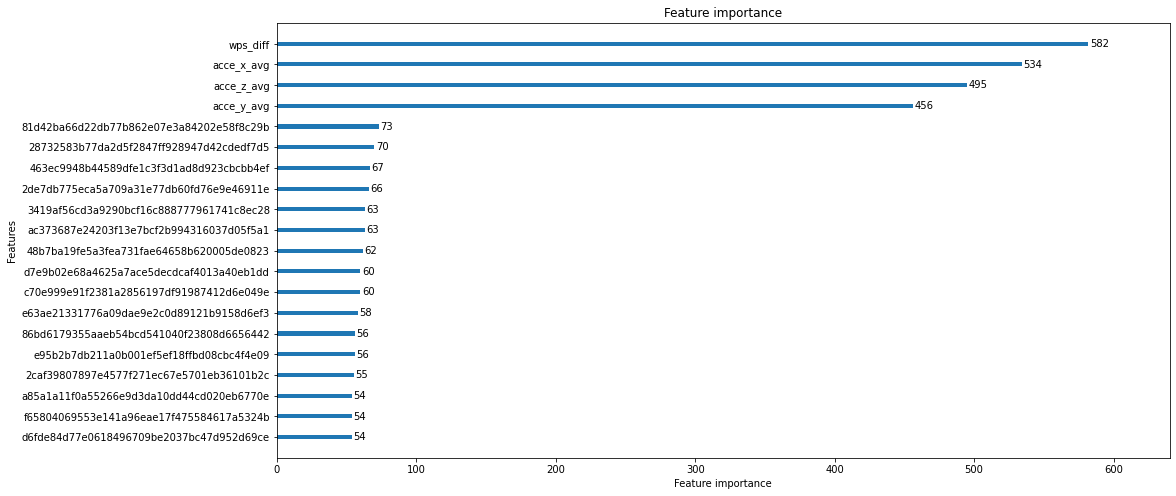

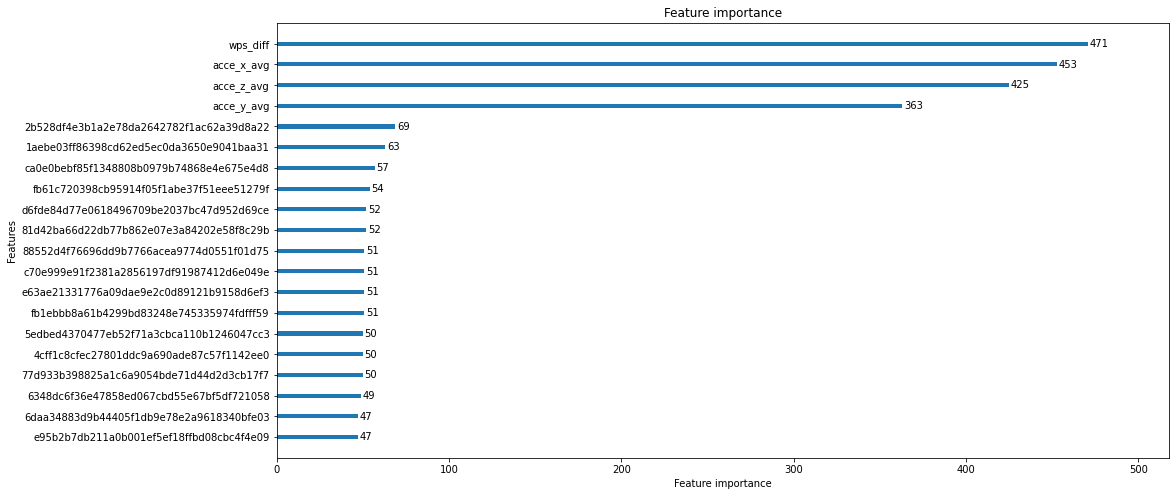

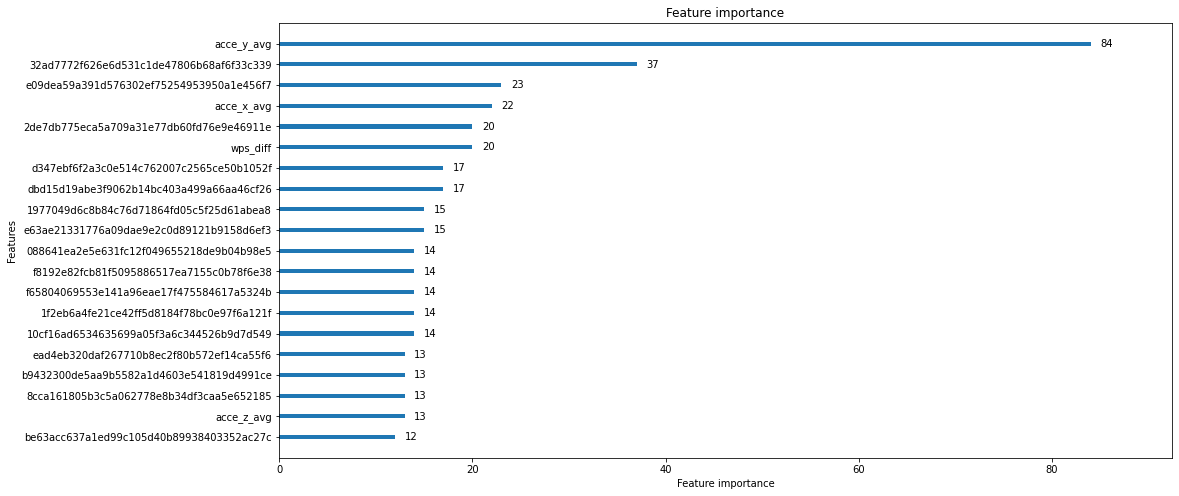

In [63]:
lgb.plot_importance(d["model_x"], max_num_features=20, grid=False, figsize=(16,8))
lgb.plot_importance(d["model_y"], max_num_features=20, grid=False, figsize=(16,8))
lgb.plot_importance(d["model_f"], max_num_features=20, grid=False, figsize=(16,8))

In [65]:
df_test = pd.read_csv("./colab_indoor/test_2/5a0546857ecc773753327266_test.csv")

In [66]:
display(df_test.head())

,site_path_timestamp,wifi_ts,wps_diff,x,y,floor,floor_int,file_id,site_id,acce_x_avg,acce_y_avg,acce_z_avg,eebf5db207eec2f3e041f92153d789270f346821,7805f319f3f591986effe78c5b41143180278f2d,323607d8444900d64151ee06d164738ac727bbce,b26914599f6d9ba16b43975394e1eeb9d82f4bab,02a1be3a5dab38320f879489d8a1e0f2a72768b3,5b225e187d0dec3110683a74d0c9a5a4cb2022f5,d84cce12fbfba61bf930123050f61a11e2a29310,b2546cae6e588d38618eacc557dd0385812197cf,6bc91b3951089c3a225396608b138ca178479924,8464ea586ee5479e1250f938d7c01e9bc68cefe8,b4dbb0b30caa1d0f21b7b4185ba061556cada67a,c48db7f3ed1858bb4fc191230e3d79d5eb178604,d771612396c3e2e557e986fafd9fc2c56a99d3cd,13b7aeaf441f2161481481fe67eace721cff07ab,dbd15d19abe3f9062b14bc403a499a66aa46cf26,c729e2e4f5a2888583cfebcd98b3178023f58b8e,bd9bc0a2092c040bfe6ba12f8aafac24e83b312a,c89453b4f0bde9488ef373a40d8821f4bf81beae,000840e5c600de293cea57f13326f273c86c3988,f64c13fd10a07bca1bf2b7bd7a80630632ce62c9,f2eb513d4c87747d0e4bc8c3bbf12951b3819678,e85bfadc24ead00bb0d80a56a2b24f5baee7da4a,ea4208f40a36b18be923fcd5adb59b250d9cef96,6915ad24a2edf8047f749233e19e9853f5dc17fd,15d53b7189ffbd7c6010c388a9ccea417d4f28ee,de53ffe7e3c71c9ed5c845fa50e0521efa5f3685,cbc6658be86ed0a5f49e670dcdb61924eee2ba0a,9ea330be4787b838d931c30f76aa9eb4ab69367e,0c75aad30012f215ae9377700feb44ee1ce42b88,15705627b6d4a0995188c4a97eb3bb604abcc401,39e2a4fb550a6b4a0feb5f0ff7b07754b1e27eaa,326e159e0dbace167726287290620e11367bb15a,85e6e3acc4f0005b00f70931e3f268bdf650956c,01da12eb27c6e37d03d691c31b40591a724db4a2,defb1317debff80bbec8fcdb53132edf3988ba93,8603dca5ec5f3485d28b66fd818ee3540301bc79,fc77794b1f306779e6d47c93b26bca7b229a6da9,69b30a314f33a8bafe26c9543bac3026b6171e18,...,e12a88f10345975e3337e9cf43a8a46fa68ffe3e,0e384fa31a858c85d686c23c84f02c539d6084d6,ca1b1ddbb06410ff4db1293fa32fa91922348cb6,1467cad993c176879919f34cdc1637ab5e719a89,f72e76e1198e03e8747cbab7d5eb7c8892236538,3e83518fabdba187f3d68e47a4751cce50e936fc,93be1230aaaa3c8f6394bfd274e6926c82b83f49,33f20983b8fae7222236a28f2fcdbfd0a64d3dae,c420057010e6ee7a7f310ea43fb563cf8b84403c,26f259dfcfeb99e4904a2fe617dab5dadce2a032,ead4eb320daf267710b8ec2f80b572ef14ca55f6,a19dac7dbdfd5b1628917159bb0333d0b4248b01,a5fa56c01bc636432ad0deb09ac769dd8b4bc4c5,c3403babce8901fd7a22f2752ee27e55c93137ef,e8af39b7dfe78bd5413b4af4a667d052e8cbaa77,fb91245a09b92f24ae14fc6e76e1b3549bd6a31d,0697d08b2741a320bcdcbb9624caca0e3a415356,2d199d76f05af1ff3432955b6b52163e8341dda5,b37d43c8c5f1e82765b5a403c19529d89b765d62,0076ff7a084cb2ac8c146139965ab1be296e72c4,b896a2a793aa802db868a7a0fdb29204bde99065,108716739163fd1a6e473359330704f7cd2068f7,e32d9e78dd87486b832f7723c916ca93ad686a54,1ad3144a286d2b32af03f8e275191f8c48c77e10,38f586d6a54a75a4fc9df0325de877b2bce5de6b,097599fa8b0d2bb4426ba0dae5ca9e578cdb8149,dc522df53e28d76a729dc56f81b1295a50ce4289,042e55ae2e3aae88070d507977eb97cd7468ef80,3b61536817d546393995f664b446e4ecf609ed61,295dcf2d00e2d19d02f73fc1d498ed5ca821161c,647649398bea2985feed4728d748939666dfb609,f3d9e7d629e50b8ca7e330d1d7cc11d6a75def8f,c70a6973225a173d7a0f74ca0ff93d07d140ed9d,a9f2d89eb253ffaf137bad7322e7cae41cd575d7,da8b535fe9eb7c6ea9388d1d2c4c80777da0fa2f,315dc4970761f38035d1da2d3592624abf1293ab,cb7c0d32ada93bf41f44aa2b37a5c584e894e040,96524d4078bf26b236a6ccc4efcf8bfb14189ab4,72a8a758661a41895e424613d666109e838b3d5f,af03d645e2ce58455848037f78dc79d962ec95d2,b831c303c1abd40fd8b242f902b6d900bca585af,c87c9fe93ddb4dc25d1d241c87a340ecf5be19f5,6bcdb1157c0d47e8a75d4ae864210156ebc2de96,817b99c65c4d92ab758443590680da2c3129c62b,563c56cbd1eba74106d9d4cf3adef19ddd574858,24f7fe5fa290f803c49bac656c57df514b180b4b,7e642dee5535c87ae5d65d225ee5dab01769b04c,ae2a68d930d314c1c164485b9ac5ef5beb158290,c5de94605289a9fae1869b9c73dde7806c559717,ed61d67ab40541ebb671536a7ea20125119cb964
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,2340,2331,-999.0,-999.0,-999.0,-999.0,046cfa46be49fc10834815c6,5a0546857ecc773753327266,0.010261,4.226973,8.941809,-45,-46,-46,-47,-47,-48,-48,-48,-48,-48,-49,-49,-49,-49,-49,-50,-50,-50,-51,-51,-51,-51,-51,-52,-52,-52,-53,-55,-5